## Predicting Loan through Linear Regression

Goal: Predict the amount of money made by a bank on a loan (money_made_inv). 
- Each row  corresponds to a loan
-  information about the loan applications, the applicants, and potential in-house evaluations of the applications. 
- Note that many of the non-numeric features are not standardized, so you should investigate both the training and test sets in order to determine how to encode them.


In [535]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
dateparse = lambda x: datetime.strptime(x, '%b-%Y')

In [536]:
#parsing columns to date-time object

train = pd.read_csv("train.csv", parse_dates={'last_credit_pull_d2': ['last_credit_pull_d']}, date_parser=dateparse)
test = pd.read_csv("test.csv", parse_dates={'last_credit_pull_d2': ['last_credit_pull_d']}, date_parser=dateparse)
#display(pd.DataFrame({'Missing Values':train.isna().sum(),'Percentage':train.isna().sum()*100/train.shape[0]}))
#train.shape
train.columns

Index(['last_credit_pull_d2', 'id', 'money_made_inv', 'acc_now_delinq',
       'acc_open_past_24mths', 'addr_state', 'annual_inc', 'application_type',
       'avg_cur_bal', 'bc_util', 'delinq_2yrs', 'delinq_amnt', 'dti',
       'earliest_cr_line', 'emp_length', 'emp_title', 'grade',
       'home_ownership', 'initial_list_status', 'int_rate', 'loan_amnt',
       'mort_acc', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_90g_dpd_24m',
       'num_tl_30dpd', 'out_prncp_inv', 'pub_rec', 'pub_rec_bankruptcies',
       'purpose', 'sub_grade', 'term', 'tot_coll_amt', 'tot_cur_bal',
       'total_rec_late_fee', 'verification_status'],
      dtype='object')

In [537]:
train.head()

,last_credit_pull_d2,id,money_made_inv,acc_now_delinq,acc_open_past_24mths,addr_state,annual_inc,application_type,avg_cur_bal,bc_util,...,out_prncp_inv,pub_rec,pub_rec_bankruptcies,purpose,sub_grade,term,tot_coll_amt,tot_cur_bal,total_rec_late_fee,verification_status
0,2019-02-01,3819,-2787.380000,0,2,CT,21120.0,Individual,3662,86.1,...,3828.54,0,0,debt_consolidation,C1,36 months,0,65921,0.0,Verified
1,2016-11-01,3820,2.436708,0,3,CA,32400.0,Individual,2973,30.2,...,0.00,3,2,debt_consolidation,C1,36 months,0,17840,0.0,Not Verified
2,2018-04-01,3821,-3.773192,0,3,NY,30251.0,Individual,1983,46.2,...,0.00,0,0,debt_consolidation,B5,36 months,0,19829,0.0,Source Verified
3,2019-02-01,3822,-7951.970000,0,1,NJ,66976.0,Individual,1638,77.4,...,9665.27,0,0,debt_consolidation,C1,60 months,0,9830,0.0,Source Verified
4,2019-02-01,3823,-8058.760000,0,2,MO,125000.0,Individual,577,0.0,...,11358.24,0,0,debt_consolidation,A2,60 months,0,6924,0.0,Source Verified


## Data Exploration

Insights 
- from pair plot => obvious linear relationship `loan_amnt` & `out_prncp_inv` => money_made_inv
-  outcome variable `money_made_inv` is very skewed, with mean of -3417 and median of -4 -> we have skewed distribution & data inbalance
- `earliest_cr_line` -> change it to only years (so we can standardize?) 
- `emp_title`, skewed distribution, 964 categorical data, bin the ones with value count <= 2 into others (aggregate)
- `emp_length` -> ordinal data, change from string to numerical 
- `grade` and `subgrade` are basically the same categorical data, high multicollinearity, can be covered by each other. 
- `delinq_2yrs`-> bin it  0, 1, 2-5, 5+  (doesn't improve the model)

### Basic Measures

In [538]:
train.columns

Index(['last_credit_pull_d2', 'id', 'money_made_inv', 'acc_now_delinq',
       'acc_open_past_24mths', 'addr_state', 'annual_inc', 'application_type',
       'avg_cur_bal', 'bc_util', 'delinq_2yrs', 'delinq_amnt', 'dti',
       'earliest_cr_line', 'emp_length', 'emp_title', 'grade',
       'home_ownership', 'initial_list_status', 'int_rate', 'loan_amnt',
       'mort_acc', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_90g_dpd_24m',
       'num_tl_30dpd', 'out_prncp_inv', 'pub_rec', 'pub_rec_bankruptcies',
       'purpose', 'sub_grade', 'term', 'tot_coll_amt', 'tot_cur_bal',
       'total_rec_late_fee', 'verification_status'],
      dtype='object')

In [539]:
train.money_made_inv.describe()

count     5778.000000
mean     -3416.502790
std       6635.846341
min     -38738.870000
25%      -4436.005000
50%         -4.114059
75%          1.872981
max      13197.780000
Name: money_made_inv, dtype: float64

In [540]:
#Check missing data: no missing data
train.isnull().sum()

last_credit_pull_d2     0
id                      0
money_made_inv          0
acc_now_delinq          0
acc_open_past_24mths    0
addr_state              0
annual_inc              0
application_type        0
avg_cur_bal             0
bc_util                 0
delinq_2yrs             0
delinq_amnt             0
dti                     0
earliest_cr_line        0
emp_length              1
emp_title               0
grade                   0
home_ownership          0
initial_list_status     0
int_rate                0
loan_amnt               0
mort_acc                0
num_sats                0
num_tl_120dpd_2m        0
num_tl_90g_dpd_24m      0
num_tl_30dpd            0
out_prncp_inv           0
pub_rec                 0
pub_rec_bankruptcies    0
purpose                 0
sub_grade               0
term                    0
tot_coll_amt            0
tot_cur_bal             0
total_rec_late_fee      0
verification_status     0
dtype: int64

#### Univariate EDA
Goal: know distribution for each potential predictors

In [541]:
train.term.value_counts

<bound method IndexOpsMixin.value_counts of 0       36 months
1       36 months
2       36 months
3       60 months
4       60 months
          ...    
5773    36 months
5774    60 months
5775    60 months
5776    60 months
5777    60 months
Name: term, Length: 5778, dtype: object>

In [542]:
train.emp_title.value_counts()

Teacher                           341
Manager                           331
Owner                             203
Registered Nurse                  151
Supervisor                        150
                                 ... 
Shareholder                         1
Senior Sales Executive              1
Air Traffic Control Specialist      1
bus operator                        1
Claims Supervisor                   1
Name: emp_title, Length: 964, dtype: int64

In [543]:
def transform(data):
    #cleaning term
    data['term'] = data['term'].str.replace('months', '')

    #cleaning emp_length
    #fill the only 1 na with 0 
    data['emp_length'] = data['emp_length'].str.replace('< 1 year', '0', regex=True)
    data['emp_length'] = data['emp_length'].str.replace('years', '', regex=True)
    data['emp_length'] = data['emp_length'].str.replace('year', '', regex=True)    
    data['emp_length'] = data['emp_length'].str.replace('+', '', regex=True)
    data['emp_length'] = data['emp_length'].str.replace(' ', '', regex=True)

    data['emp_length'] = data['emp_length'].fillna(0)
    
    data['emp_length'] = data['emp_length'].astype('int')

    ### binning employment title column '
    # count the value occurrences in column A
    value_counts = data['emp_title'].value_counts()
    # identify values with count <= 2
    values_to_change1 = value_counts[value_counts <= 2].index.tolist()
    # replace the identified values with a new value (e.g., -1)
    data.loc[data['emp_title'].isin(values_to_change1), 'emp_title'] = 'other1'
    
    values_to_change2 = value_counts[value_counts <= 5].index.tolist()
    data.loc[data['emp_title'].isin(values_to_change2), 'emp_title'] = 'other2'

transform(train)
transform(test)

In [544]:
train.emp_title.value_counts()

other1              798
other2              504
Teacher             341
Manager             331
Owner               203
                   ... 
SALES                 6
Regional Manager      6
Rn                    6
Security              6
Loan Officer          6
Name: emp_title, Length: 169, dtype: int64

In [545]:
#check predictors distribution
train.apply(lambda x: x.value_counts()).T.stack()


/var/folders/gb/7c0y49jn1r1cdlhcjrzqhm_w0000gn/T/ipykernel_27932/3133428368.py:2: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  train.apply(lambda x: x.value_counts()).T.stack()
/var/folders/gb/7c0y49jn1r1cdlhcjrzqhm_w0000gn/T/ipykernel_27932/3133428368.py:2: RuntimeWarning: '<' not supported between instances of 'float' and 'Timestamp', sort order is undefined for incomparable objects.
  train.apply(lambda x: x.value_counts()).T.stack()


last_credit_pull_d2  2019-02-01 00:00:00    3621.0
                     2019-01-01 00:00:00     209.0
                     2018-07-01 00:00:00     174.0
                     2018-10-01 00:00:00     158.0
                     2018-08-01 00:00:00     147.0
                                             ...  
total_rec_late_fee   98.42                     1.0
                     253.96                    1.0
verification_status  Source Verified        2488.0
                     Not Verified           1976.0
                     Verified               1314.0
Length: 31998, dtype: float64

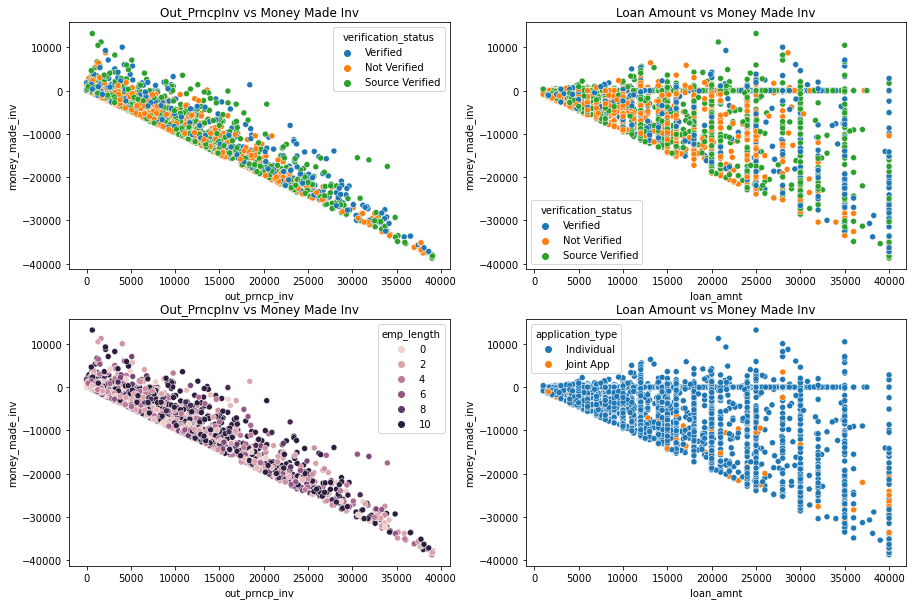

In [546]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize = (15, 10))
sns.scatterplot(ax=axes[0,0], data = train, x = "out_prncp_inv", y = "money_made_inv", hue = "verification_status")
axes[0,0].set_title('Out_PrncpInv vs Money Made Inv');
sns.scatterplot(ax=axes[0,1], data = train, x = "loan_amnt", y = "money_made_inv", hue = "verification_status")
axes[0,1].set_title('Loan Amount vs Money Made Inv');

sns.scatterplot(ax=axes[1,0], data = train, x = "out_prncp_inv", y = "money_made_inv", hue = "emp_length")
axes[1,0].set_title('Out_PrncpInv vs Money Made Inv');

sns.scatterplot(ax=axes[1,1], data = train, x = "loan_amnt", y = "money_made_inv", hue = "application_type")
axes[1,1].set_title('Loan Amount vs Money Made Inv');

## Out Prncp Category Special Case
- Huge Imbalance in outprncp

0    3334
1    2444
Name: out_prncp_inv_categorical, dtype: int64

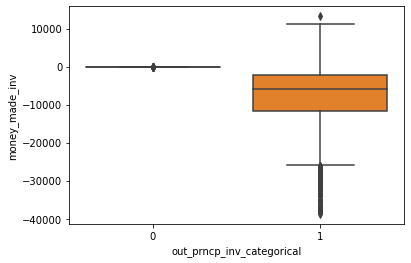

In [547]:
train2 = train.copy()
train2['out_prncp_inv_categorical'] = 0
train2.loc[train2['out_prncp_inv']> 0, 'out_prncp_inv_categorical'] = 1
sns.boxplot(y = train2['money_made_inv'], x = train2['out_prncp_inv_categorical'])

display(train2.out_prncp_inv_categorical.value_counts())

## Category Encoding

In [561]:
import category_encoders as ce

strType_l = []
for i in range(len(train2.T)):
    if isinstance(train2.iloc[0][i], str):
        strType_l.append(train2.columns[i])

display(strType_l)

target_l =[]
for i in strType_l:
    if len(train[i].unique()) > 4:
        target_l.append(i)

display(target_l)

['addr_state',
 'application_type',
 'earliest_cr_line',
 'emp_title',
 'grade',
 'home_ownership',
 'initial_list_status',
 'purpose',
 'sub_grade',
 'term',
 'verification_status']

['addr_state',
 'earliest_cr_line',
 'emp_title',
 'grade',
 'purpose',
 'sub_grade']

In [551]:
# Create the encoder
target_enc = ce.TargetEncoder(cols = target_l)
target_enc.fit(train[target_l], train2['out_prncp_inv'])

# Transform the features, rename the columns with _target suffix, and join to dataframe
train_TE = train2.join(target_enc.transform(train2[target_l]).add_suffix('_target'))
train_TE.columns

Index(['last_credit_pull_d2', 'id', 'money_made_inv', 'acc_now_delinq',
       'acc_open_past_24mths', 'addr_state', 'annual_inc', 'application_type',
       'avg_cur_bal', 'bc_util', 'delinq_2yrs', 'delinq_amnt', 'dti',
       'earliest_cr_line', 'emp_length', 'emp_title', 'grade',
       'home_ownership', 'initial_list_status', 'int_rate', 'loan_amnt',
       'mort_acc', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_90g_dpd_24m',
       'num_tl_30dpd', 'out_prncp_inv', 'pub_rec', 'pub_rec_bankruptcies',
       'purpose', 'sub_grade', 'term', 'tot_coll_amt', 'tot_cur_bal',
       'total_rec_late_fee', 'verification_status',
       'out_prncp_inv_categorical', 'addr_state_target',
       'earliest_cr_line_target', 'emp_title_target', 'grade_target',
       'purpose_target', 'sub_grade_target'],
      dtype='object')

<AxesSubplot:>

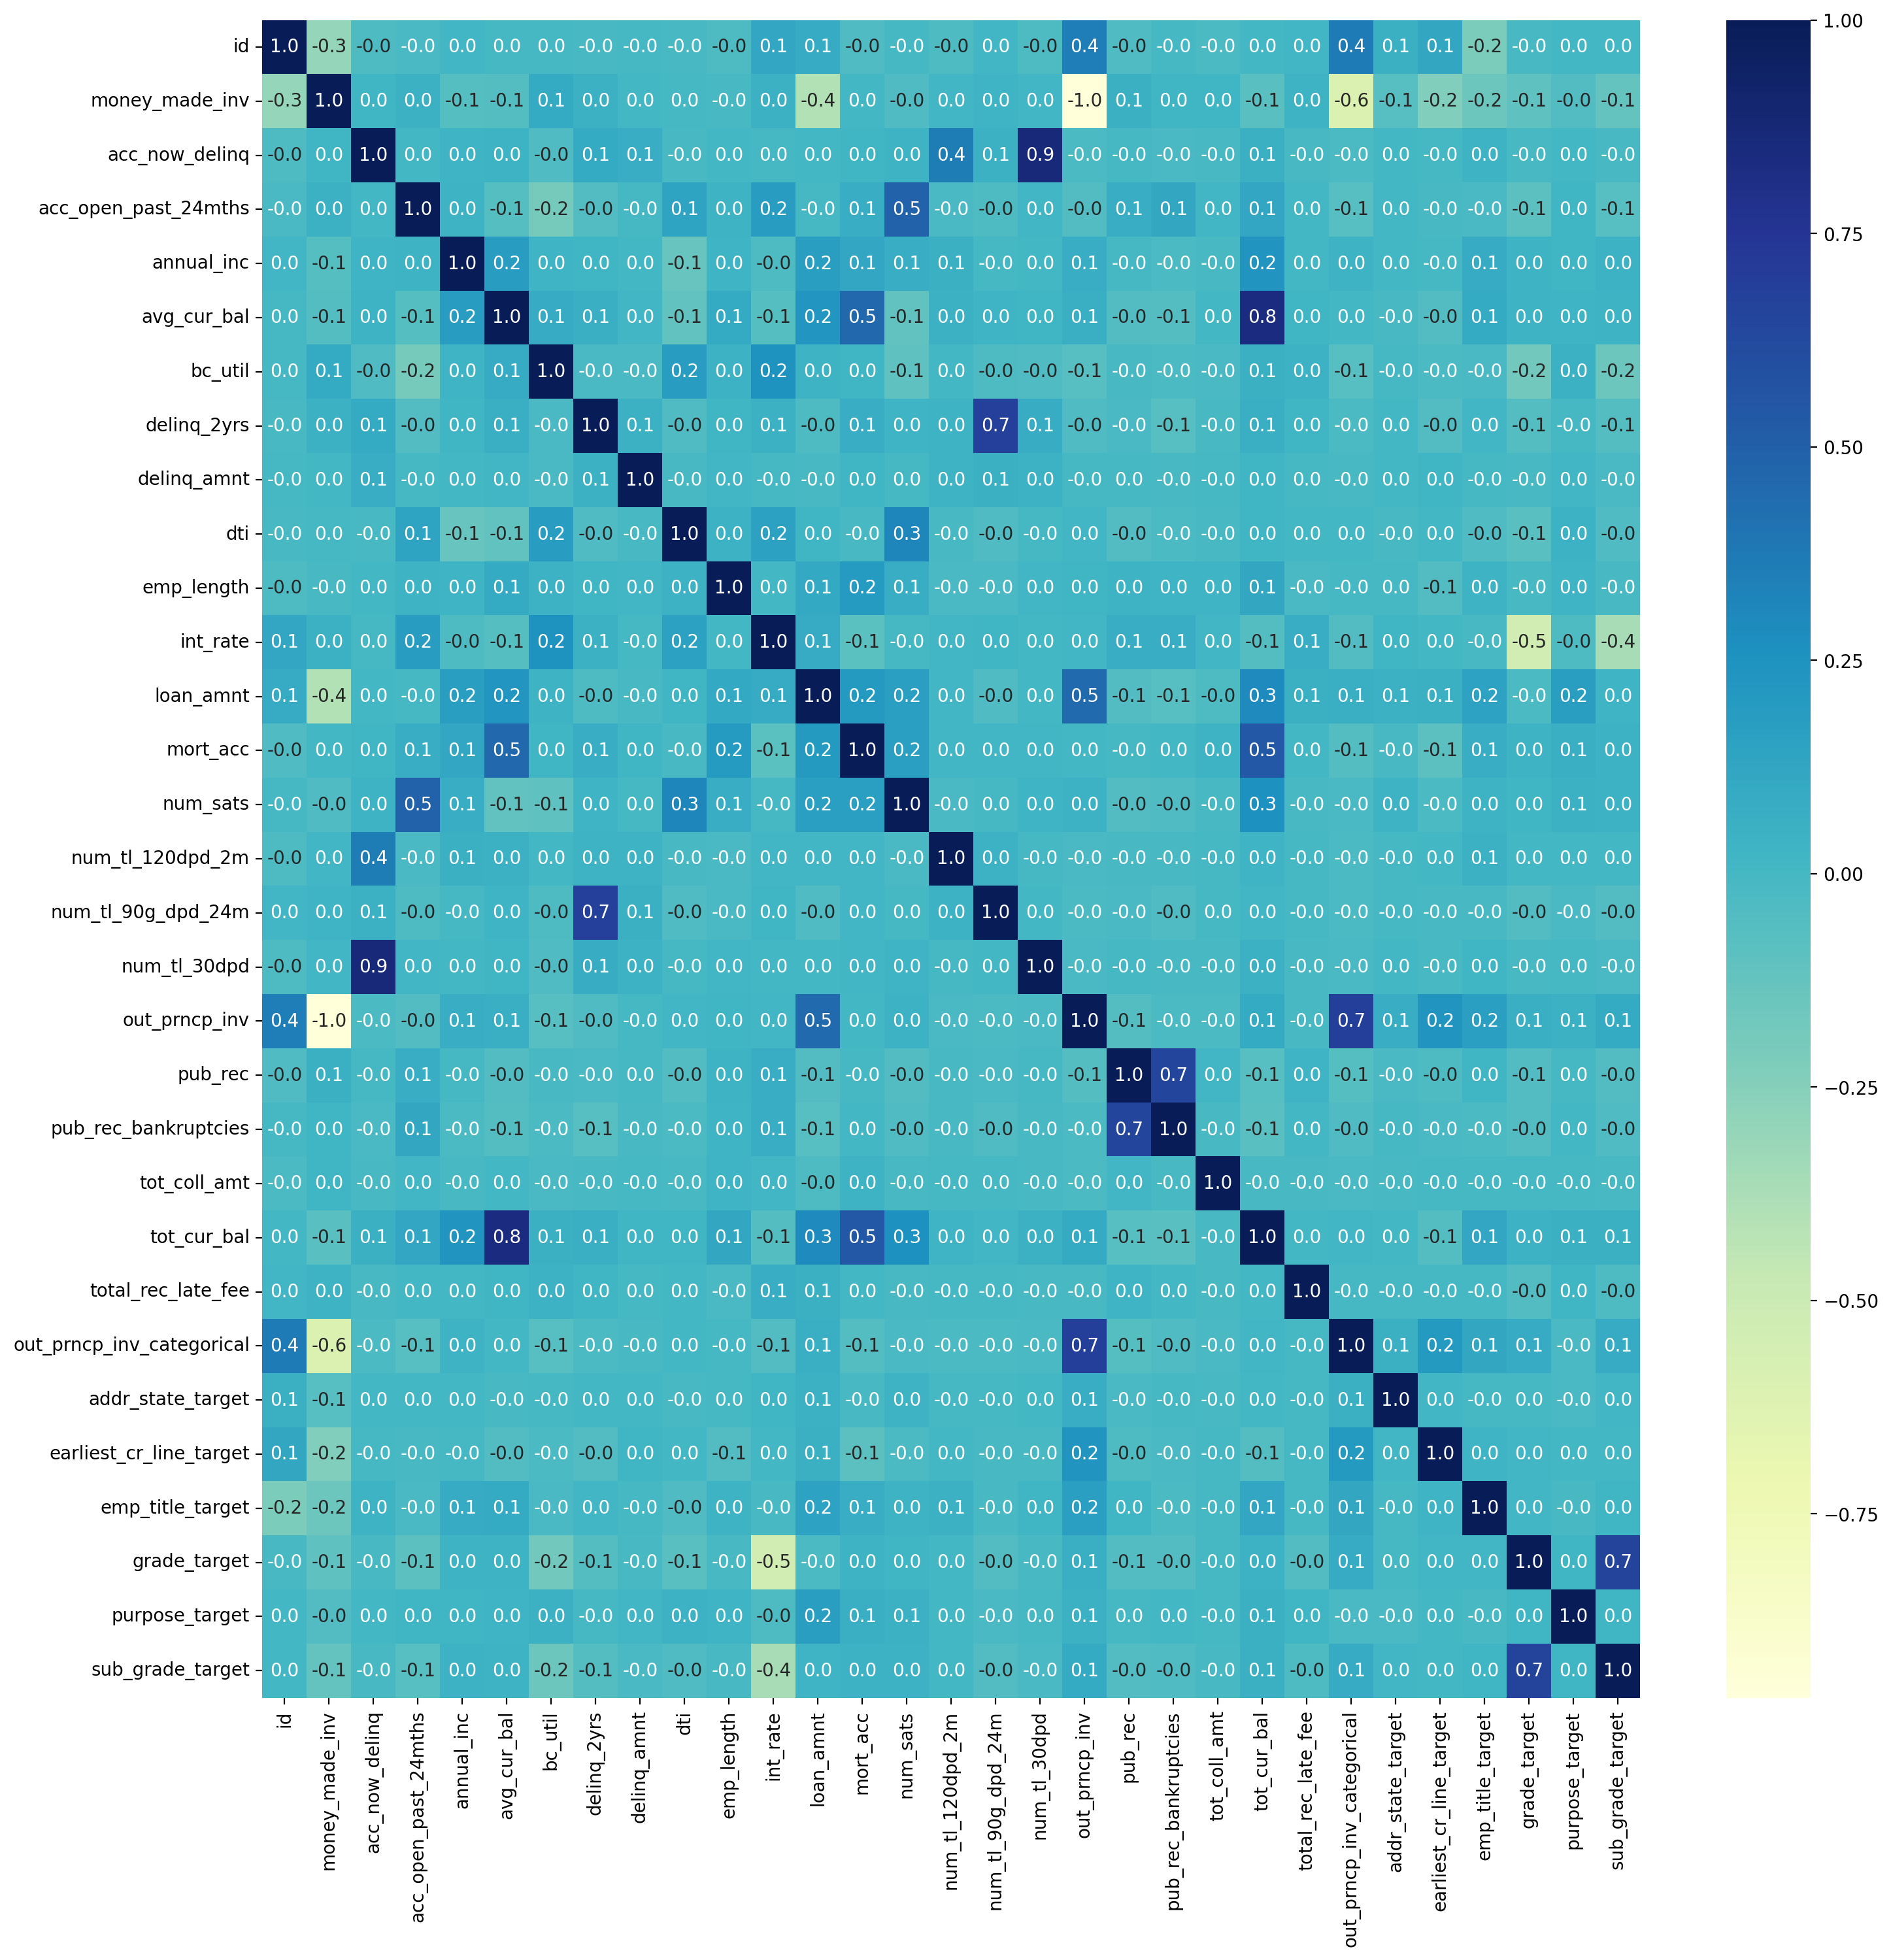

In [552]:
plt.figure(figsize = (17,17), dpi = 200)
sns.heatmap(train_TE.corr(), annot = True, fmt = ".1f", cmap = "YlGnBu")

In [553]:
train_TE.columns

Index(['last_credit_pull_d2', 'id', 'money_made_inv', 'acc_now_delinq',
       'acc_open_past_24mths', 'addr_state', 'annual_inc', 'application_type',
       'avg_cur_bal', 'bc_util', 'delinq_2yrs', 'delinq_amnt', 'dti',
       'earliest_cr_line', 'emp_length', 'emp_title', 'grade',
       'home_ownership', 'initial_list_status', 'int_rate', 'loan_amnt',
       'mort_acc', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_90g_dpd_24m',
       'num_tl_30dpd', 'out_prncp_inv', 'pub_rec', 'pub_rec_bankruptcies',
       'purpose', 'sub_grade', 'term', 'tot_coll_amt', 'tot_cur_bal',
       'total_rec_late_fee', 'verification_status',
       'out_prncp_inv_categorical', 'addr_state_target',
       'earliest_cr_line_target', 'emp_title_target', 'grade_target',
       'purpose_target', 'sub_grade_target'],
      dtype='object')

In [554]:
model = smf.ols(formula = 'money_made_inv~out_prncp_inv*loan_amnt+loan_amnt*term+out_prncp_inv*term+I(out_prncp_inv**2)+int_rate+int_rate*out_prncp_inv+int_rate*term', data = train_TE).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         money_made_inv   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                 2.520e+04
Date:                Sat, 25 Feb 2023   Prob (F-statistic):               0.00
Time:                        12:48:53   Log-Likelihood:                -48068.
No. Observations:                5778   AIC:                         9.616e+04
Df Residuals:                    5767   BIC:                         9.623e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                   127.0861     56.771      2.239      0.025      15.794     238.378
term[T.60 ]                 156.0722    126.637      1.232      0.218     -92.185     404.329
out_prncp_inv                -1.0826      0.008   -140.448      0.000      -1.098      -1.067
out_prncp_inv:term[T.60 ]     0.0702      0.005     15.395      0.000       0.061       0.079
loan_amnt                    -0.0068      0.002     -3.212      0.001      -0.011      -0.003
loan_amnt:term[T.60 ]         0.0031      0.004      0.793      0.428      -0.005       0.011
out_prncp_inv:loan_amnt    2.863e-05   3.81e-07     75.153      0.000    2.79e-05    2.94e-05
I(out_prncp_inv ** 2)     -3.401e-05   3.79e-07    -89.669      0.000   -3.48e-05   -3.33e-05
int_rate                      5.9553      3.972      1.499      0.134      -1.831      13.742
int_rate:term[T.60 ]          7.6053      6.467      1.176      0.240      -5.073      20.283
int_rate:out_prncp_inv        0.0130      0.000     32.826      0.000       0.012       0.014
==============================================================================
Omnibus:                     4174.163   Durbin-Watson:                   1.920
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           163347.052
Skew:                           3.006   Prob(JB):                         0.00
Kurtosis:                      28.345   Cond. No.                     3.18e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.18e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Predictions

In [555]:
#adding target_encoding to test_dataset
target_l =[]
for i in strType_l:
    if len(train[i].unique()) > 4:
        target_l.append(i)

# Create the encoder
target_enc = ce.TargetEncoder(cols = target_l)
target_enc.fit(test[target_l], test['out_prncp_inv'])

# Transform the features, rename the columns with _target suffix, and join to dataframe
test_TE = test.join(target_enc.transform(test[target_l]).add_suffix('_target'))
#test_TE.columns
test_TE.shape

(3818, 41)

In [556]:
#test 2 = with out_prncp_inv_categorical
test2 = test.copy()
test2['out_prncp_inv_categorical'] = 0
test2.loc[test2['out_prncp_inv']> 0, 'out_prncp_inv_categorical'] = 1

In [557]:
# #test 3 = with out_prncp_inv_categorical + last_credit_pull_d_target (target encoding)
# test3 = test2.copy()
# test3['last_credit_pull_d_target'] = test_TE.last_credit_pull_d_target
# test3.shape

In [558]:
prediction_train = model.predict(train_TE)
print(np.sqrt(((train.money_made_inv - prediction_train)**2).mean()))

prediction_s = model.predict(test3)

prediction_s.shape

992.4728197874202


(3818,)

## Formatting & Saving to CSV

In [559]:
prediction = pd.DataFrame(prediction_s, columns=['Predicted'])
prediction.index = test.id
prediction.index.name = 'id'

prediction.shape

(3818, 1)

In [560]:
prediction.to_csv(r'/Users/juliachu/Dropbox/Northwestern/2022-2023/2.WQ/STAT 303-2/kaggle/LinearRegression/prediction.csv', header=True, index=True)